## Importing Libraries and Datasets

In [ ]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import re
import ast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
df=pd.read_csv('crm_activities_100_voc.csv')

In [ ]:
df.rename(columns={
    "POTENTIALID": "deal_id",
    "ACTIVITY_TIMESTAMP": "timestamp",
    "ACTIVITY": "activity_type",
    "CONTACTID": "contact_id",
    "ACCOUNTID": "account_id",
    "CALL_VOC": "call_voc",
    "EMAIL_VOC": "email_voc",
    "EVENT_VOC": "event_voc",
    "INVOICE_VOC": "invoice_voc",
    "QUOTE_VOC": "quote_voc",
    "SALESORDER_VOC": "salesorder_voc",
    "DEALSTAGE": "deal_stage",
    "CLASS_TAG": "class_tag",
    "INVOICEGRANDTOTAL": "deal_amount",
}, inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"])

## Extracting and mapping VOC columns

In [ ]:
# Mapping activity_type to corresponding voc column
voc_mapping = {
    'mail': 'email_voc',
    'call': 'call_voc',
    'meeting': 'event_voc',
    'quote': 'quote_voc',
    'salesorder': 'salesorder_voc',
    'invoice': 'invoice_voc'
}

# Function to get voc dict based on activity_type
def extract_voc(row):
    voc_col = voc_mapping.get(row['activity_type'])
    voc_data = row[voc_col]
    if pd.isna(voc_data):
        return None
    if isinstance(voc_data, str):
        try:
            voc_data = ast.literal_eval(voc_data)  # convert string dict to actual dict
        except Exception:
            return None
    return voc_data if isinstance(voc_data, dict) else None

# Extract into separate columns
df['voc_dict'] = df.apply(extract_voc, axis=1)
df['sentiment'] = df['voc_dict'].apply(lambda x: x.get('sentiment') if isinstance(x, dict) else None)
df['intent'] = df['voc_dict'].apply(lambda x: x.get('intent') if isinstance(x, dict) else None)
df['emotion'] = df['voc_dict'].apply(lambda x: x.get('emotion') if isinstance(x, dict) else None)

# Drop temp column if not needed
df.drop(columns=['voc_dict'], inplace=True)

# Assigning scores to value
sentiment_map = {"positive": 1, "neutral": 0.5, "negative": 0.2}
intent_map = {
    "purchase": 1.0, "gratitude": 0.9, "request": 0.8, "query": 0.6,
    "complaint": 0.2, "others": 0.3
}
emotion_map = {
    "happy": 1.0, "gratitude": 0.9, "trust": 0.9,
    "neutral": 0.5, "confusion": 0.3, "frustration": 0.2, "discontentment": 0.2
}

# Mapping scores to value
df["sentiment_score"] = df["sentiment"].map(sentiment_map)
df["intent_score"] = df["intent"].map(intent_map)
df["emotion_score"] = df["emotion"].map(emotion_map)

# Handling missing values
df['intent_score'] = df['intent_score'].fillna(df['intent_score'].mean())
df['sentiment_score'] = df['sentiment_score'].fillna(df['sentiment_score'].mean())
df['emotion_score'] = df['emotion_score'].fillna(df['emotion_score'].mean())

df1=df.copy()

## Helper Functions

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
def compute_avg_slope(row):
    # Use slopes already calculated for the deal
    score = np.mean([row['sentiment_slope'], row['intent_slope'], row['emotion_slope']])
    return round(score, 4)

In [ ]:
def interpret_trend(scores, feature_name="", min_net_change=0.05, min_speed=0.01):
    clean = [s for s in scores if s is not None and not np.isnan(s)]
    n = len(clean)
    if n < 2:
        return {"label": "Insufficient Data", "n": n}

    x = np.arange(n)
    slope = np.polyfit(x, clean, 1)[0]
    net_change = slope * (n - 1)

    direction = "Improving" if net_change > 0 else "Worsening" if net_change < 0 else "Stable"

    # if abs(net_change) < min_net_change:
    #     label = "Stable"
    if abs(slope) >= min_speed:
        label = f"{direction} fast"
    else:
        label = f"{direction} slowly"

    return {
        "label": label,
        "slope": round(slope, 5),
        "net_change": round(net_change, 3),
        "n": n
    }

In [ ]:
def combine_trends(sentiment_label, intent_label, emotion_label):
    """Combine 3 labels into a single overall label."""
    trends = [sentiment_label, intent_label, emotion_label]

    improving_count = sum("Improving" in t for t in trends)
    worsening_count = sum("Worsening" in t for t in trends)

    if improving_count >= 2:
        return "Overall Improving"
    elif worsening_count >= 2:
        return "Overall Worsening"
    else:
        return "Overall Stable"

In [ ]:
def label_deal_info(label, deal_duration_days, class_tag):
    """
    Modifies the label based on actual deal outcome and time taken.
    """
    outcome = class_tag.lower()

    trend_label = label

    # Adjust for outcome
    if "improving" in label.lower() and outcome == "closed lost":
        trend_label += f" but Lost"
    elif "improving" in label.lower() and outcome == "closed won":
        trend_label += f" and Won"
    elif "worsening" in label.lower() and outcome == "closed won":
        trend_label += f" but Won"
    elif "worsening" in label.lower() and outcome == "closed lost":
        trend_label += f" and Lost"
    else:
        result = "Won" if outcome == "closed won" else "Lost"
        trend_label += f" but {result}"

    # Adjust for deal speed
    if deal_duration_days < 10:
        trend_label += f" - Quick Cycle(<10days)"
    elif deal_duration_days > 60:
        trend_label += f" - Long Cycle(>60days)"
    else:
        trend_label += f" - Normal Cycle(20-60days)"

    return trend_label

## Feature Extraction

In [ ]:
def engineer_activity_features(df):
    """
    Input: raw dataframe with rows per activity
    Output: dataframe with one row per activity containing both deal-level
            engineered features and activity-level info (with timestamp preserved)
    """

    # Ensure timestamp is datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    enriched_rows = []

    for deal_id, group in df.groupby('deal_id'):
        # --- Basic deal metadata ---
        group = group.sort_values('timestamp')
        deal_amount = group['deal_amount'].dropna().mean()
        last_deal_stage = group['deal_stage'].iloc[-1]
        deal_stages = group["deal_stage"].nunique()
        deal_duration_days = (group['timestamp'].max() - group['timestamp'].min()).days
        activity_count = group.shape[0]
        num_voc_touches = group['activity_type'].nunique()

        # Calculate trends (entire deal history)
        intent_result = interpret_trend(group['intent_score'].tolist(), "intent")
        sentiment_result = interpret_trend(group['sentiment_score'].tolist(), "sentiment")
        emotion_result = interpret_trend(group['emotion_score'].tolist(), "emotion")

        # Combine into one label
        overall_label = combine_trends(sentiment_result['label'],
                                       intent_result['label'],
                                       emotion_result['label'])

        # Apply deal context
        class_tag = group['class_tag'].iloc[-1]
        class_tag_encoded = 1 if class_tag == "closed won" else 0
        overall_label = label_deal_info(overall_label, deal_duration_days, class_tag)

        for _, row in group.iterrows():
            enriched = row.to_dict()
            enriched.update({
                # Deal-level features
                "deal_amount": deal_amount,
                "deal_duration_days": deal_duration_days,
                "activity_count": activity_count,

                # Activity scores
                "sentiment_score": enriched['sentiment_score'],
                "intent_score": enriched['intent_score'],
                "emotion_score": enriched['emotion_score'],

                # Trends
                "sentiment_slope": sentiment_result['slope'],
                "intent_slope": intent_result['slope'],
                "emotion_slope": emotion_result['slope'],

                # Target
                "class_tag_encoded": class_tag_encoded,
            })

            for col_to_remove in ["deal_stage", "last_deal_stage", "class_tag", "activity_type", "deal_stages"]:
              enriched.pop(col_to_remove, None)

            enriched_rows.append(enriched)

    return pd.DataFrame(enriched_rows)

df.drop(columns=['email_voc', 'call_voc', 'event_voc', 'quote_voc', 'salesorder_voc', 'invoice_voc', 'intent','sentiment', 'emotion', 'contact_id', 'account_id'], axis=1, inplace=True)

deal_level_features = engineer_activity_features(df)

display(deal_level_features.head(2))

,deal_id,timestamp,deal_amount,sentiment_score,intent_score,emotion_score,deal_duration_days,activity_count,sentiment_slope,intent_slope,emotion_slope,class_tag_encoded
0,01421d86-5916-4993-b3da-4997d981549f,2025-06-11 11:46:23.195106,6388.0,0.5,0.8,0.5,0,8,0.07143,0.06667,0.07619,1
1,01421d86-5916-4993-b3da-4997d981549f,2025-06-11 11:56:23.195106,6388.0,0.5,0.3,0.5,0,8,0.07143,0.06667,0.07619,1


## Data Handling

In [ ]:
# Filling missing values and feature engineering

deal_level_features['avg_slope'] = deal_level_features.apply(compute_avg_slope, axis=1)
deal_level_features['deal_amount'].fillna(deal_level_features['deal_amount'].mean(), inplace=True)

# Standardize numeric features

cols = ["deal_duration_days", "activity_count", "deal_amount"]
scaler = StandardScaler()
deal_level_features[cols] = scaler.fit_transform(deal_level_features[cols])

df = deal_level_features.copy()
df.head()

/tmp/ipython-input-221579321.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  deal_level_features['deal_amount'].fillna(deal_level_features['deal_amount'].mean(), inplace=True)


,deal_id,timestamp,deal_amount,sentiment_score,intent_score,emotion_score,deal_duration_days,activity_count,sentiment_slope,intent_slope,emotion_slope,class_tag_encoded,avg_slope
0,01421d86-5916-4993-b3da-4997d981549f,2025-06-11 11:46:23.195106,0.49035,0.5,0.8,0.5,0.0,0.964901,0.07143,0.06667,0.07619,1,0.0714
1,01421d86-5916-4993-b3da-4997d981549f,2025-06-11 11:56:23.195106,0.49035,0.5,0.3,0.5,0.0,0.964901,0.07143,0.06667,0.07619,1,0.0714
2,01421d86-5916-4993-b3da-4997d981549f,2025-06-11 12:06:23.195106,0.49035,1.0,0.8,0.9,0.0,0.964901,0.07143,0.06667,0.07619,1,0.0714
3,01421d86-5916-4993-b3da-4997d981549f,2025-06-11 12:16:23.195106,0.49035,1.0,0.8,0.9,0.0,0.964901,0.07143,0.06667,0.07619,1,0.0714
4,01421d86-5916-4993-b3da-4997d981549f,2025-06-11 12:26:23.195106,0.49035,1.0,0.9,1.0,0.0,0.964901,0.07143,0.06667,0.07619,1,0.0714


## Sequence Data Preparation for LSTM

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Get latest timestamp per deal
deal_timestamps = df.groupby('deal_id')['timestamp'].max()

# Sort deal IDs by timestamp ascending (earliest to latest)
sorted_deal_ids = deal_timestamps.sort_values().index.tolist()

maxlen = 30
feature_cols = ['sentiment_score', 'intent_score', 'emotion_score', 'sentiment_slope', 'intent_slope', 'emotion_slope', 'activity_count', 'deal_amount', 'deal_duration_days']

# Group activities per deal
deals = []
results = []
deal_id_list = []

for deal_id in sorted_deal_ids:
    group = df[df['deal_id'] == deal_id].sort_values('timestamp')
    seq = group[feature_cols].values
    padded_seq = pad_sequences([seq], maxlen=maxlen, dtype='float32', padding='pre', truncating='post', value=0.0)[0]
    deals.append(padded_seq)
    tag = group['class_tag_encoded'].iloc[-1]
    results.append(tag)
    deal_id_list.append(deal_id)

X = np.stack(deals)
Y = np.array(results)

## Data Splitting

In [ ]:
split_index = int(len(X) * 0.9)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = Y[:split_index], Y[split_index:]

train_deal_ids, test_deal_ids = deal_id_list[:split_index], deal_id_list[split_index:]

train_timestamps = [deal_timestamps[deal_id] for deal_id in train_deal_ids]
test_timestamps = [deal_timestamps[deal_id] for deal_id in test_deal_ids]

## LSTM Model Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

model = Sequential([
    Masking(mask_value=0.0, input_shape=(maxlen, len(feature_cols))),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 1.0640 - mae: 0.9448 - val_loss: 0.5625 - val_mae: 0.6483
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4867 - mae: 0.5984 - val_loss: 0.3257 - val_mae: 0.4313
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2697 - mae: 0.4097 - val_loss: 0.2193 - val_mae: 0.3994
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1715 - mae: 0.3348 - val_loss: 0.1286 - val_mae: 0.3252
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0789 - mae: 0.2360 - val_loss: 0.0569 - val_mae: 0.2192
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0580 - mae: 0.2088 - val_loss: 0.0253 - val_mae: 0.1246
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0389 - mae: 0.1545 - val_loss: 0.0243 - val_mae: 0.1400
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0397 - mae: 0.1486 - val_loss: 0.0218 - val_mae: 0.1317
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0237 - mae: 0.1206 - val_loss: 

## Prediction

In [ ]:
def serve_trend(new_seq):
  new_seq = pad_sequences([new_seq], maxlen=maxlen, dtype='float32', padding='pre', truncating='post', value=0.0)
  pred_score = float(model.predict(new_seq))

  if pred_score > 0.7:
      pred_trend = 'UPTREND'
  elif pred_score < 0.3:
      pred_trend = 'DOWNTREND'
  else:
      pred_trend = 'STABLE'

  return {
        "timestamp": datetime.now().isoformat(),
        "pred_score": round(pred_score, 4),
        "label": pred_trend,
    }

for i in range(len(X_test)):
  new_seq = X_test[i]
  print(json.dumps(serve_trend(new_seq), indent=2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
{
  "timestamp": "2025-08-28T14:31:54.216679",
  "pred_score": 1.0464,
  "label": "UPTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
{
  "timestamp": "2025-08-28T14:31:54.339766",
  "pred_score": 0.9939,
  "label": "UPTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/tmp/ipython-input-2267123515.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_score = float(model.predict(new_seq))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
{
  "timestamp": "2025-08-28T14:31:54.436295",
  "pred_score": 1.0098,
  "label": "UPTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
{
  "timestamp": "2025-08-28T14:31:54.523610",
  "pred_score": 0.0549,
  "label": "DOWNTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
{
  "timestamp": "2025-08-28T14:31:54.645002",
  "pred_score": 1.0136,
  "label": "UPTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
{
  "timestamp": "2025-08-28T14:31:54.771039",
  "pred_score": 0.9998,
  "label": "UPTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
{
  "timestamp": "2025-08-28T14:31:54.900049",
  "pred_score": 0.1473,
  "label": "DOWNTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
{
  "timestamp": "2025-08-28T14:31:54.989674",
  "pred_score": 1.0044,
  "label": "UPTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
{
  "timestamp": "2025-08-28T14:31:55.130157",
  "pred_score": 1.0623,
  "label": "UPTREND"
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
{
  "timestamp": "2025-08-28T14:31

## Trend View

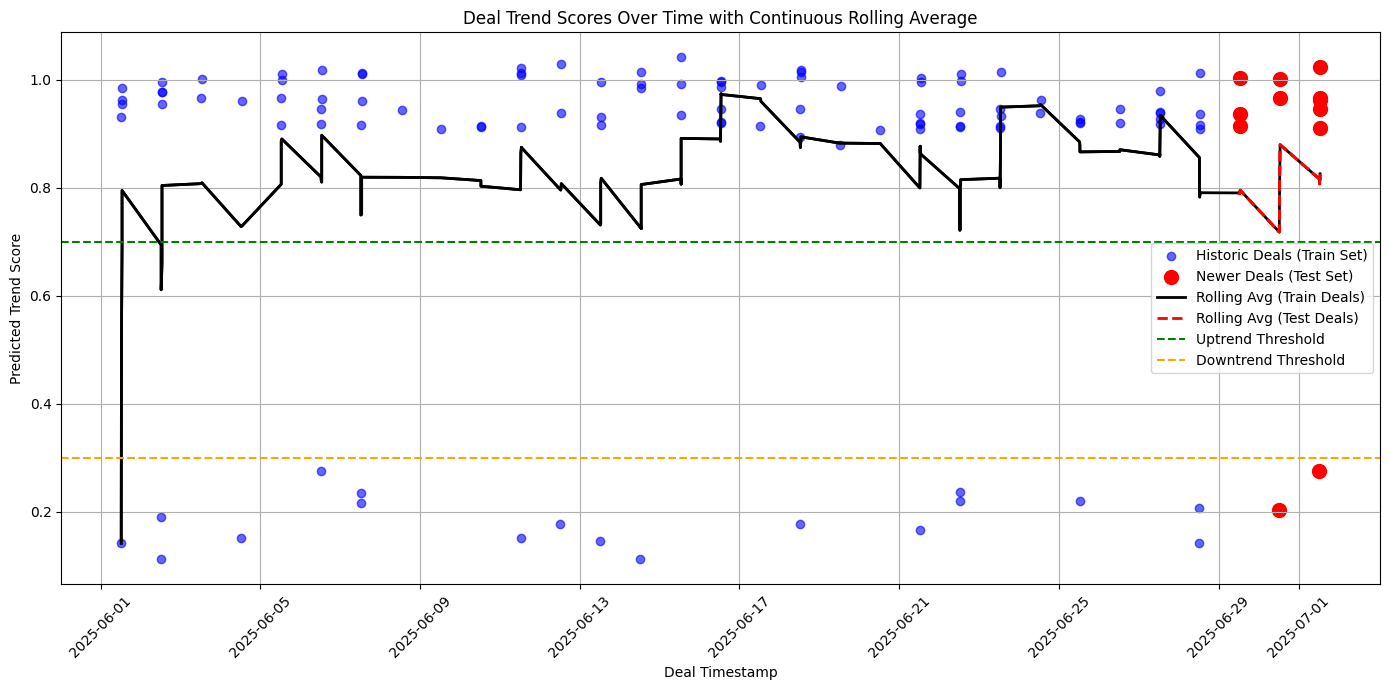

In [ ]:
# Combine train + test
all_df = pd.concat([
    pd.DataFrame({'timestamp': train_timestamps, 'score': train_scores, 'set': 'train'}),
    pd.DataFrame({'timestamp': test_timestamps, 'score': test_scores, 'set': 'test'})
]).sort_values('timestamp')

# Rolling average across ALL deals
all_df['rolling_avg'] = all_df['score'].rolling(window=10, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 7))
plt.scatter(all_df[all_df['set']=='train']['timestamp'], all_df[all_df['set']=='train']['score'],
            color='blue', alpha=0.6, label='Historic Deals (Train Set)', marker='o')
plt.scatter(all_df[all_df['set']=='test']['timestamp'], all_df[all_df['set']=='test']['score'],
            color='red', s=100, label='Newer Deals (Test Set)', marker='o')

# Split rolling avg into train vs test
train_df = all_df[all_df['set'] == 'train']
test_df = all_df[all_df['set'] == 'test']

# Plot full rolling average line in black (continuous)
plt.plot(all_df['timestamp'], all_df['rolling_avg'], color='black', linewidth=2)

# Overlay only the test portion in red (same line, but recolored)
plt.plot(all_df[all_df['set']=='test']['timestamp'], all_df[all_df['set']=='test']['rolling_avg'],
         color='red', linewidth=2, linestyle='--')

# Rolling avg line for train
plt.plot(train_df['timestamp'], train_df['rolling_avg'], color='black', linewidth=2, label='Rolling Avg (Train Deals)')

# Rolling avg line for test
plt.plot(test_df['timestamp'], test_df['rolling_avg'], color='red', linewidth=2, linestyle='--', label='Rolling Avg (Test Deals)')

# Thresholds
plt.axhline(0.7, color='green', linestyle='--', label='Uptrend Threshold')
plt.axhline(0.3, color='orange', linestyle='--', label='Downtrend Threshold')

plt.title('Deal Trend Scores Over Time with Continuous Rolling Average')
plt.xlabel('Deal Timestamp')
plt.ylabel('Predicted Trend Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
